# 逻辑回归

本脚本展示如何使用TensorFlow来解决

$ \textbf{y} = sigmoid(\textbf{A}\times \textbf{x} + \textbf{b})$

我们使用低生育率数据集：
```
#  y = 0 or 1 = low birth weight
#  x = demographic and medical history data
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
from tensorflow.python.framework import ops
import os.path
import csv

/home/zhangxin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
ops.reset_default_graph()

# 创建计算图会话
sess = tf.Session()

## Obtain and prepare data for modeling

In [3]:
# 数据文件名
birth_weight_file = 'birth_weight.csv'

# 下载数据，如果不存在.csv文件则创建文件
if not os.path.exists(birth_weight_file):
    
    birthdata_url = 'https://github.com/nfmcclure/tensorflow_cookbook/' + \
    'raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] 
                  for y in birth_data[1:] if len(y)>=1]
    with open(birth_weight_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(birth_header)
        writer.writerows(birth_data)
        f.close()

# 读取出生率数据到内存中
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
     csv_reader = csv.reader(csvfile)
     birth_header = next(csv_reader)
     for row in csv_reader:
         birth_data.append(row)

birth_data = [[float(x) for x in row] for row in birth_data]

# 得到目标列表
y_vals = np.array([x[0] for x in birth_data])
# 得到预测变量（去掉id,和目标，以及出生率）
x_vals = np.array([x[1:8] for x in birth_data])

# 设置随机种子
seed = 99
np.random.seed(seed)
tf.set_random_seed(seed)

# 按照80-20的比例分割数据集为训练数据集和验证数据集（在sklearn中可以使用train_test_split）
# 注意样本均衡的问题。
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

# 按照列来实现归一化（极大极小归一化）
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)
    
x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

## 定义TensorFlow的计算图

In [4]:
# 声明批尺寸大小（为了提高GPU资源利用率，一般将这个批尺寸设为2的幂次方）
batch_size = 25

# 占位符
x_data = tf.placeholder(shape=[None, 7], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# 变量
A = tf.Variable(tf.random_normal(shape=[7,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# 模型计算
model_output = tf.add(tf.matmul(x_data, A), b)

# 声明损失函数（交叉熵损失）
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# 优化器（当然是最小化交叉熵）
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

## 训练模型

In [5]:
# 初始化变量
init = tf.global_variables_initializer()
sess.run(init)

# 实际预测值
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# 迭代训练
loss_vec = []
train_acc = []
test_acc = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    temp_acc_train = sess.run(accuracy, 
                              feed_dict={x_data: x_vals_train, 
                                         y_target: np.transpose([y_vals_train])})
    train_acc.append(temp_acc_train)
    temp_acc_test = sess.run(accuracy, 
                             feed_dict={x_data: x_vals_test, 
                                        y_target: np.transpose([y_vals_test])})
    test_acc.append(temp_acc_test)
    if (i+1)%300==0:
        print('Loss = ' + str(temp_loss))
        

Loss = 0.6944471
Loss = 0.7304496
Loss = 0.62496805
Loss = 0.69695
Loss = 0.6096429


## 显示模型的性能

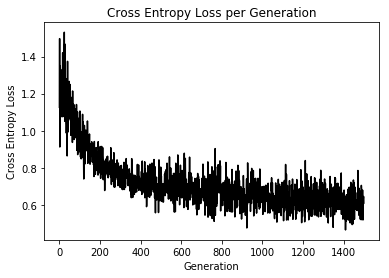

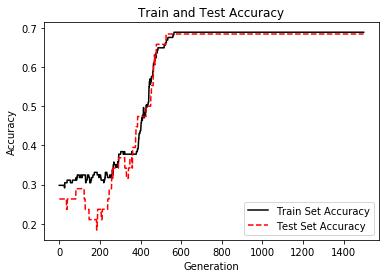

In [6]:
%matplotlib inline
# 画出损失随训练轮数的变化
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

# 画出训练和测试精确度
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()